In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax import random

import pandas as pd
import matplotlib.pyplot as plt

import time
import sys
import os

p = os.path.abspath(os.path.join('..', '00_utils'))

# Add the directory to sys.path
if p not in sys.path:
    sys.path.append(p)

from collocation import compute_weights, lagrange_derivative
#from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
#from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
#from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
# RELOADING MODULES
import importlib
import neural_net_jax
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

import data_generation
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

# ----------------- diffrax code -----------------
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.nn as jnn
import jax.random as jr
import optax  # https://github.com/deepmind/optax


In [3]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 400
noise_level = 0.05
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [4]:
u_noisy = np.atleast_2d(y_noisy).T
r, c = u_noisy.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 400; c : 1
r : 400; c : 1


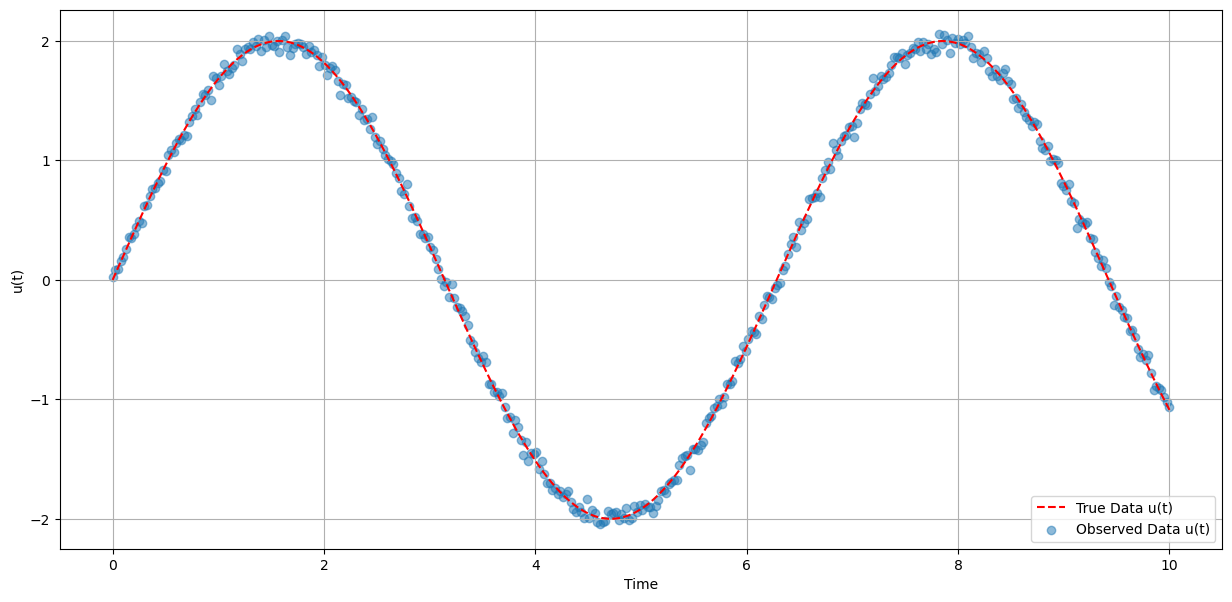

In [5]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')

plt.plot(t, y, 'r--', label='True Data u(t)') 
plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `Regular JAX Odeint training`

In [6]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):
        if x.ndim == 2:
             embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        elif x.ndim == 1:
            embedding = jnp.array([x[i + j * tau] for j in range(m)])     
        else:
            raise ValueError("Input array x must be either 1D or 2D.")
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)

In [7]:
tau = 1
m = 5
embeddings = create_delayed_embeddings(y_noisy, tau, m)

* t[offset : i]
* embeddings[: i - offset]
* the train-test split is set at 300 + offset

In [8]:
embeddings.shape

(395, 5)

In [10]:
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

In [11]:
y_pred_results = {}
offset = m * tau

layer_widths = [1 + m, 32, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)
state = node_model.create_train_state(rng, learning_rate)

for i in [50, 300]:
    state = node_model.train(state, t[offset:i + offset], u_noisy[offset:i + offset], 
                             y[offset], num_epochs = 1000, 
                             extra_args = (embeddings[: i], t[offset:i + offset]))
#state = node_model.train(state, t, u_noisy, y[0], num_epochs = 1000)

Epoch 100, Loss: 1.3757352512646401
Epoch 200, Loss: 1.1494056663695367
Epoch 300, Loss: 0.9081864824553874
Epoch 400, Loss: 0.6723803513804367
Epoch 500, Loss: 0.46397490658765217
Epoch 600, Loss: 0.3012177359927263
Epoch 700, Loss: 0.1931924353244868
Epoch 800, Loss: 0.1346767994216099
Epoch 900, Loss: 0.10899327774141117
Epoch 1000, Loss: 0.09941723834700111
Epoch 100, Loss: 106.49729741271719
Epoch 200, Loss: 57.80398139327764
Epoch 300, Loss: 38.521496625802016
Epoch 400, Loss: 28.527663808975277
Epoch 500, Loss: 22.470348983812087
Epoch 600, Loss: 18.40821586058884
Epoch 700, Loss: 15.473399590112264


* train predictions can be done using the original `embeddings` vector

In [161]:
offset

5

In [166]:
y_train_pred = node_model.neural_ode(state_archive.params, y[offset], t[offset : 300+offset], state_archive, (embeddings[:300], t[offset : 300+offset]))

IndexError: tuple index out of range

In [ ]:
# y_train_pred = node_model.neural_ode(state_archive.params, y[offset], t[offset : 300+offset], state_archive, (embeddings[:300], t[offset : 300+offset]))
# y_train_pred = node_model.neural_ode(PARAMS, INITIAL_STATE, TIME POINTS INCLUDING INITIAL STATE, STATE, (EMBEDDING, TIME POINT OF THE EMDEDDING))

In [93]:
print(f'The last training point is {300+offset}')
print(f'Training is until (non inclusive) {"300+offset"}')
print(f'The test range is from {300+offset+1} to {len(y_noisy)}')

The last training point is 305
Training is until (non inclusive) 300+offset
The test range is from 306 to 400


* Let's create a vector where points within the test range are unknown
* to ensure there is no data leakage 

In [83]:
y_noisy_embeddings = y_noisy

for i in range(300+offset, len(y_noisy)):
    y_noisy_embeddings[i] = np.nan

In [98]:
def fetch_embeddings(y, tau, m, index):
    # use slicing to get the embeddings
    return y[index - (m - 1) * tau : index + 1 : tau]

In [156]:
fetch_embeddings(y_noisy_embeddings, 1, 5, 35)

array([1.43342352, 1.38200078, 1.48779382, 1.55550197, 1.54899786])

In [155]:
init_value = y_noisy_embeddings[300+offset]

# for every test point
for current_index in range(300+offset+1, len(y_noisy)):
    print(f'Current index is {current_index}')
    # check that the embedding for all the test points is empty
    print(y_noisy_embeddings[current_index])
    
    # fetch the embedding for the current index
    embeddings = fetch_embeddings(y_noisy_embeddings, tau, m, current_index)
    # print(embeddings)
    if np.isnan(embeddings).any():
        print('There are missing values in the embeddings')

    current_value = node_model.neural_ode(state.params, init_value, t[current_index - 1 : current_index], state, (embeddings, np.nan))
    
    # current value becomes the initial value for the next iteration
    init_value = current_value
    # save the current value to the noisy embeddings
    y_noisy_embeddings[current_index] = current_value

Current index is 306
0.0
[1.94337094 1.93559936 1.99214588 0.         0.        ]


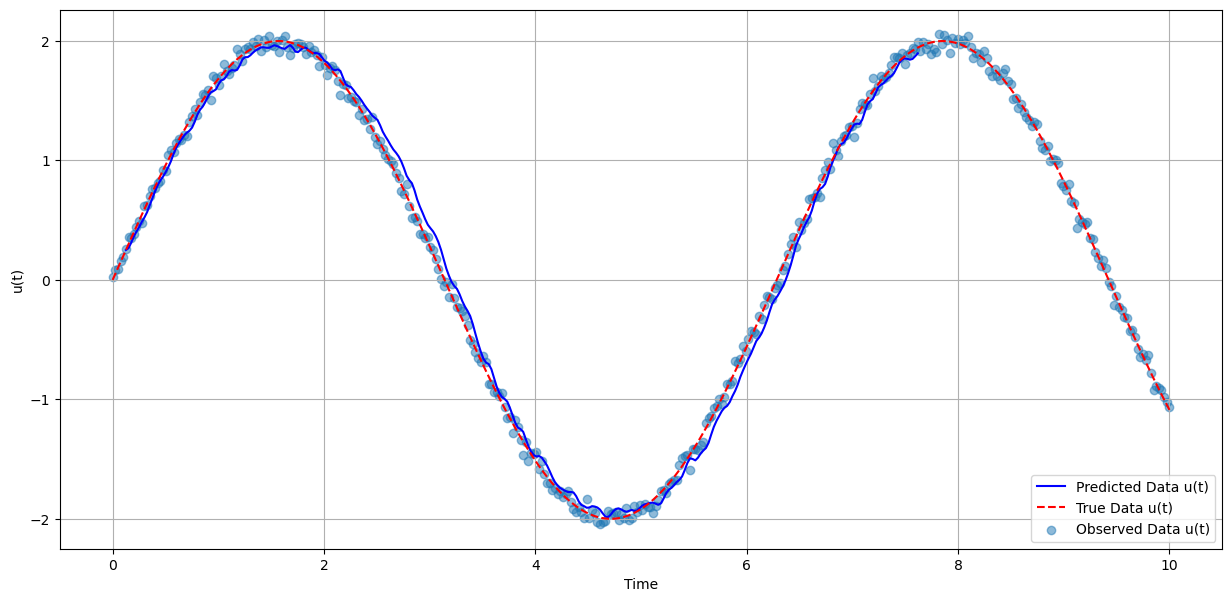

In [79]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')

plt.plot(t[offset : 300+offset], y_train_pred, 'b', label='Predicted Data u(t)') 
plt.plot(t, y, 'r--', label='True Data u(t)') 
plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 
#plt.scatter(t[:i], u_noisy[:i], label='Observed Data u(t)', alpha=1) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()